In [15]:
import pandas as pd
import theano
import theano.tensor as T
import numpy as np
import lasagne
import random
import matplotlib.pyplot as plt
import math
from IPython import display
import json

In [2]:
%matplotlib inline

In [68]:
class ConfusionMatrix(object):
    def __init__(self, preds, reals):
        assert len(preds) == len(reals)
        self.preds = preds
        self.reals = reals
        classes = sorted(set(preds) | set(reals))
        mat = np.zeros([len(classes), len(classes)], dtype="int")
        for real, pred in zip(reals, preds):
            mat[classes.index(real), classes.index(pred)] += 1
        self.mat = mat     
            
    def __str__(self):
        return str(self.mat)
    
    def bac(self):
        return (self.mat.diagonal() / self.mat.sum(1)).mean()

In [10]:
df = pd.read_csv("../Data/Mulleder_et_al_data.tsv", sep="\t").iloc[:, 2:-1]

output = 5
print(df.columns[output])
Y = df.iloc[:, output].values
X = df[[c for i, c in enumerate(df.columns) if i != output]].values

histidine


In [9]:
print({col: i for i, col in enumerate(df.columns)})

{'methionine': 9, 'serine': 14, 'arginine': 13, 'leucine': 8, 'alanine': 0, 'phenylalanine': 3, 'tryptophan': 17, 'glycine': 4, 'lysine': 7, 'isoleucine': 6, 'histidine': 5, 'threonine': 15, 'glutamine': 12, 'proline': 11, 'valine': 16, 'glutamate': 2, 'aspartate': 1, 'tyrosine': 18, 'asparagine': 10}


In [11]:
order = random.sample(range(len(X)), len(X))
X = X[order]
Y = Y[order]

splitpoint = int(0.85 * len(df))

X_train = X[:splitpoint]
Y_train = Y[:splitpoint]
X_test = X[splitpoint:]
Y_test = Y[splitpoint:]

In [12]:
# Define model
BATCH_SIZE = 100
NUM_INPUTS = X_train.shape[1]

x_sym = T.matrix("x_sym")
y_sym = T.vector("y_sym")

l_in = lasagne.layers.InputLayer((None, NUM_INPUTS))

l_1 = lasagne.layers.DenseLayer(l_in, 30, nonlinearity=lasagne.nonlinearities.leaky_rectify)
l_2 = lasagne.layers.DenseLayer(l_1, 30, nonlinearity=lasagne.nonlinearities.leaky_rectify)
l_3 = lasagne.layers.DenseLayer(l_2, 30, nonlinearity=lasagne.nonlinearities.leaky_rectify)
l_4 = lasagne.layers.DenseLayer(l_3, 30, nonlinearity=lasagne.nonlinearities.leaky_rectify)

l_out = lasagne.layers.DenseLayer(l_2, 1, nonlinearity=lasagne.nonlinearities.linear)

In [13]:
print("Input layer", lasagne.layers.get_output(l_in, inputs={l_in: x_sym}).eval({x_sym: X_test}).shape)
print("Input layer", lasagne.layers.get_output(l_out, inputs={l_in: x_sym}).eval({x_sym: X_test}).shape)

Input layer (702, 18)
Input layer (702, 1)


In [14]:
# Retrieve network output
train_out = lasagne.layers.get_output(l_out, inputs={l_in: x_sym}, deterministic=False)
eval_out = lasagne.layers.get_output(l_out, inputs={l_in: x_sym}, deterministic=True)

all_params = lasagne.layers.get_all_params(l_out, trainable=True)

def huber_loss(target, output, delta=5):
    diff = target - output
    absdiff = abs(diff)
    ift = 0.5 * (diff ** 2)
    iff = delta * (absdiff - delta / 2.)
    return T.switch(absdiff <= delta, ift, iff).sum()

cost = lasagne.objectives.squared_error(train_out, y_sym).mean()
#cost = T.abs_(train_out - y_sym).mean()
#cost = huber_loss(y_sym, train_out, 10)

#cost_eval = lasagne.objectives.squared_error(eval_out, y_sym)

all_grads = T.grad(cost, all_params)

updates = lasagne.updates.adadelta(all_grads, all_params, learning_rate=2) #, learning_rate=0.002)

f_eval = theano.function([x_sym],
                     eval_out, on_unused_input='warn')

f_train = theano.function(
    [x_sym, y_sym],
    cost,
    updates=updates, on_unused_input='warn'
)

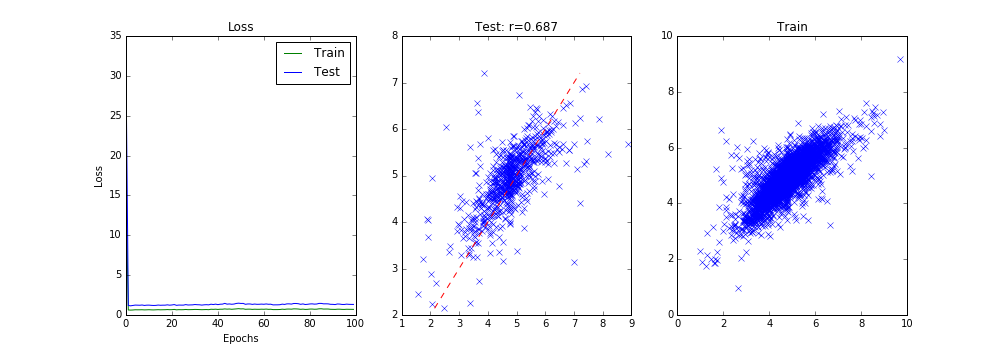

99


In [15]:
EPOCHS = 100
BATCH_SIZE = 10

train_losses = []
test_losses = []

for epoch in range(EPOCHS):
    for j in range(1):
        for i in range(math.ceil(len(X_train)/BATCH_SIZE)):
            x_batch = X_train[i*BATCH_SIZE: (i+1)*BATCH_SIZE]
            y_batch = Y_train[i*BATCH_SIZE: (i+1)*BATCH_SIZE]

            #f_train({x_sym: x_batch, y_sym: y_batch, A_sym: A_hat, ymask_sym: mask_batch})
            if epoch != 0:
                batch_train_loss = f_train(x_batch, y_batch)
        
    test_output = f_eval(X_test)
    train_output = f_eval(X_train)
    test_loss = lasagne.objectives.squared_error(test_output, Y_test).mean().eval()
    train_loss = 0.5 * lasagne.objectives.squared_error(train_output, Y_train).mean().eval()
    
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    
    plt.figure(figsize=[14, 5])
    plt.subplot(1, 3, 1)
    plt.plot(list(range(epoch+1)), train_losses, "g", label="Train")
    plt.plot(list(range(epoch+1)), test_losses, "b", label="Test")
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss")
    
    plt.subplot(1, 3, 2)
    plt.plot(Y_test, test_output, "xb")
    min_val = max(Y_test.min(), test_output.min())
    max_val = min(Y_test.max(), test_output.max())
    plt.plot([min_val, max_val], [min_val, max_val], "--r")
    plt.title("Test: r=" + str(round(np.corrcoef(Y_test, test_output[:, 0])[0, 1], 3)))
    
    plt.subplot(1, 3, 3)
    plt.plot(Y_train, train_output, "xb")
    plt.title("Train")
    
    
    plt.savefig("out2.png")
    plt.close()
    display.display(display.Image(filename="out2.png"))
    
    print(epoch)
    
    display.clear_output(wait=True)

In [207]:
diff = x_sym
delta = 5
absdiff = abs(diff)
ift = 0.5 * (diff ** 2)
iff = delta * (absdiff - delta / 2.)
hubs = T.switch(absdiff <= delta, ift, iff)

In [208]:
X = np.arange(-20, 20, 0.1)
Y = hubs.eval({x_sym: np.stack([X])})

In [209]:
Y.shape

(1, 400)

In [210]:
X.shape

(400,)

(0, 160)

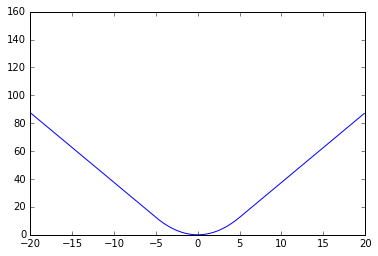

In [211]:

#Y = huber_loss(X, X-X).eval()

plt.plot(X, Y[0])
plt.ylim([0, 160])

(200,)

In [109]:
np.corrcoef(Y_test, test_output)

ValueError: all the input array dimensions except for the concatenation axis must match exactly

In [111]:
Y_test

(702,)

In [112]:
test_output.shape

(702, 1)

alanine
aspartate
glutamate
phenylalanine
glycine
histidine
isoleucine
lysine
leucine
methionine
asparagine
proline
glutamine
arginine
serine
threonine
valine
tryptophan
tyrosine


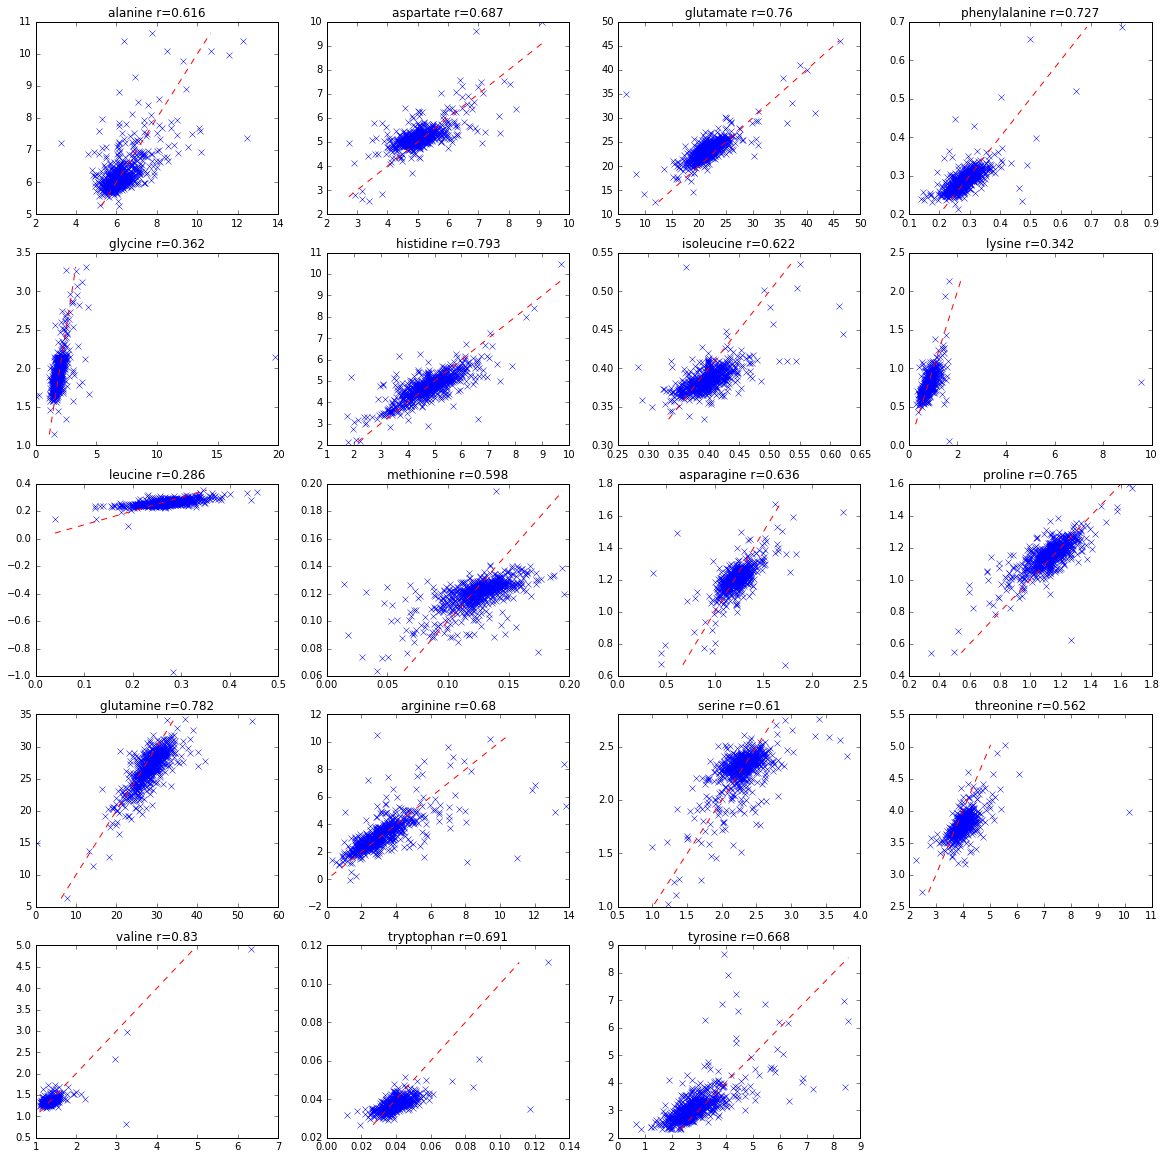

In [133]:
plt.figure(figsize=[20, 20])

for output in range(19):
    df = pd.read_csv("../Data/Mulleder_et_al_data.tsv", sep="\t").iloc[:, 2:-1]

    compound = df.columns[output]
    print(compound)
    
    Y = df.iloc[:, output].values
    X = df[[c for j, c in enumerate(df.columns) if j != output]].values
    
    order = random.sample(range(len(X)), len(X))
    X = X[order]
    Y = Y[order]

    splitpoint = int(0.85 * len(df))

    X_train = X[:splitpoint]
    Y_train = Y[:splitpoint]
    X_test = X[splitpoint:]
    Y_test = Y[splitpoint:]
    
    # Define model
    BATCH_SIZE = 100
    NUM_INPUTS = X_train.shape[1]

    x_sym = T.matrix("x_sym")
    y_sym = T.vector("y_sym")

    l_in = lasagne.layers.InputLayer((None, NUM_INPUTS))

    l_1 = lasagne.layers.DenseLayer(l_in, 30, nonlinearity=lasagne.nonlinearities.leaky_rectify)
    l_2 = lasagne.layers.DenseLayer(l_1, 30, nonlinearity=lasagne.nonlinearities.leaky_rectify)
    l_3 = lasagne.layers.DenseLayer(l_2, 30, nonlinearity=lasagne.nonlinearities.leaky_rectify)
    l_4 = lasagne.layers.DenseLayer(l_3, 30, nonlinearity=lasagne.nonlinearities.leaky_rectify)

    l_out = lasagne.layers.DenseLayer(l_3, 1, nonlinearity=lasagne.nonlinearities.linear)

    # Retrieve network output
    train_out = lasagne.layers.get_output(l_out, inputs={l_in: x_sym}, deterministic=False)
    eval_out = lasagne.layers.get_output(l_out, inputs={l_in: x_sym}, deterministic=True)

    all_params = lasagne.layers.get_all_params(l_out, trainable=True)


    cost = lasagne.objectives.squared_error(train_out, y_sym).mean()

    #cost_eval = lasagne.objectives.squared_error(eval_out, y_sym)

    all_grads = T.grad(cost, all_params)

    updates = lasagne.updates.adadelta(all_grads, all_params, learning_rate=1.0) #, learning_rate=0.002)

    f_eval = theano.function([x_sym],
                         eval_out, on_unused_input='warn')

    f_train = theano.function(
        [x_sym, y_sym],
        cost,
        updates=updates, on_unused_input='warn'
    )
    
    EPOCHS = 50
    BATCH_SIZE = 10

    train_losses = []
    test_losses = []
    
    best_corr = -2

    for epoch in range(EPOCHS):
        for j in range(1):
            for i in range(math.ceil(len(X_train)/BATCH_SIZE)):
                x_batch = X_train[i*BATCH_SIZE: (i+1)*BATCH_SIZE]
                y_batch = Y_train[i*BATCH_SIZE: (i+1)*BATCH_SIZE]

                #f_train({x_sym: x_batch, y_sym: y_batch, A_sym: A_hat, ymask_sym: mask_batch})
                if epoch != 0:
                    batch_train_loss = f_train(x_batch, y_batch)

        test_output = f_eval(X_test)
        train_output = f_eval(X_train)
        test_loss = lasagne.objectives.squared_error(test_output, Y_test).mean().eval()
        train_loss = 0.5 * lasagne.objectives.squared_error(train_output, Y_train).mean().eval()
        
        test_cor = np.corrcoef(Y_test, test_output[:, 0])[0, 1]
        if test_cor > best_corr:
            best_test_output = test_output
        
        train_losses.append(train_loss)
        test_losses.append(test_loss)

    plt.subplot(5, 4, output+1)
    plt.plot(Y_test, best_test_output, "xb")
    
    min_val = max(Y_test.min(), best_test_output.min())
    max_val = min(Y_test.max(), best_test_output.max())
    plt.plot([min_val, max_val], [min_val, max_val], "--r")
    
    plt.title(compound + " r=" + str(round(np.corrcoef(Y_test, best_test_output[:, 0])[0, 1], 3)))
    
plt.savefig("../Plots/Metabolite_conc_predictions.pdf")

In [29]:
data = np.load("../Data/Permuted_data1.npz")

with open("../Data/aa_indices.json") as infile:
    aa_indices = json.load(infile)
    del aa_indices["cysteine"]
    
aa_idx_list = np.array(sorted(aa_indices.values()))

In [154]:
results = {}

for aa in aa_indices:
    print(aa)

    X = data["X"]
    Y = data["Y"]
    cat_Y = data["cat_Y"]
    covariates = Y.copy()

    splitpoint = 75

    # Only predict one metabolite
    aa_mask = np.zeros_like(Y)
    aa_mask[:, aa_indices[aa]] = 1
    Y = Y * aa_mask

    mask = (Y != 0).astype("float")
    cat_Y = cat_Y * mask


    covariates[:, aa_indices[aa]] = 0
    X = np.concatenate([X, covariates], axis=2)

    # Amplify knockout signal
    X[:, :, 0] *= 3000

    Y = cat_Y

    X_train = X[:splitpoint][:, aa_idx_list, -1]
    Y_train = Y[:splitpoint][:, aa_indices[aa]]
    X_test = X[splitpoint:][:, aa_idx_list, -1]
    Y_test = Y[splitpoint:][:, aa_indices[aa]]

    mask_train = mask[:splitpoint][:, aa_indices[aa]]
    mask_test = mask[splitpoint:][:, aa_indices[aa]]

    train_cat_counts = Y_train.sum(0)
    train_cat_factors = [train_cat_counts.max() / cnt for cnt in train_cat_counts]
    #print(train_cat_counts)
    #print(np.array(cat_counts) - np.array(train_cat_counts))

    for i, fact in enumerate(train_cat_factors):
        mask_train[:, 0] *= (Y_train[:, i] == 1).astype("int") * (fact - 1) + 1

    # Define model
    BATCH_SIZE = 100
    NUM_INPUTS = X_train.shape[1]

    x_sym = T.matrix("x_sym")
    y_sym = T.matrix("y_sym")

    l_in = lasagne.layers.InputLayer((None, NUM_INPUTS))

    l_1 = lasagne.layers.DenseLayer(l_in, 20, nonlinearity=lasagne.nonlinearities.leaky_rectify)
    l_drop_1 = lasagne.layers.DropoutLayer(l_1, p=0.3)

    l_2 = lasagne.layers.DenseLayer(l_drop_1, 20, nonlinearity=lasagne.nonlinearities.leaky_rectify)
    l_drop_2 = lasagne.layers.DropoutLayer(l_2, p=0.3)

    l_3 = lasagne.layers.DenseLayer(l_drop_2, 20, nonlinearity=lasagne.nonlinearities.leaky_rectify)
    l_drop_3 = lasagne.layers.DropoutLayer(l_3, p=0.3)

    l_4 = lasagne.layers.DenseLayer(l_drop_3, 20, nonlinearity=lasagne.nonlinearities.leaky_rectify)
    l_drop_4 = lasagne.layers.DropoutLayer(l_4, p=0.3)


    l_out = lasagne.layers.DenseLayer(l_drop_3, 2, nonlinearity=lasagne.nonlinearities.softmax)

    # Retrieve network output
    train_out = lasagne.layers.get_output(l_out, inputs={l_in: x_sym}, deterministic=False)
    eval_out = lasagne.layers.get_output(l_out, inputs={l_in: x_sym}, deterministic=True)

    all_params = lasagne.layers.get_all_params(l_out, trainable=True)

    def huber_loss(target, output, delta=5):
        diff = target - output
        absdiff = abs(diff)
        ift = 0.5 * (diff ** 2)
        iff = delta * (absdiff - delta / 2.)
        return T.switch(absdiff <= delta, ift, iff).sum()

    cost = lasagne.objectives.squared_error(train_out, y_sym).mean()

    all_grads = T.grad(cost, all_params)

    updates = lasagne.updates.adadelta(all_grads, all_params, learning_rate=1) #, learning_rate=0.002)

    f_eval = theano.function([x_sym],
                         eval_out, on_unused_input='warn')

    f_train = theano.function(
        [x_sym, y_sym],
        cost,
        updates=updates, on_unused_input='warn'
    )

    EPOCHS = 50
    BATCH_SIZE = 10

    train_losses = []
    test_losses = []
    
    best_bac = 0

    for epoch in range(EPOCHS):
        for j in range(1):
            for i in range(math.ceil(len(X_train)/BATCH_SIZE)):
                x_batch = X_train[i*BATCH_SIZE: (i+1)*BATCH_SIZE]
                y_batch = Y_train[i*BATCH_SIZE: (i+1)*BATCH_SIZE]

                #f_train({x_sym: x_batch, y_sym: y_batch, A_sym: A_hat, ymask_sym: mask_batch})
                if epoch != 0:
                    batch_train_loss = f_train(x_batch, y_batch)

        test_output = f_eval(X_test)
        train_output = f_eval(X_train)
        test_loss = lasagne.objectives.squared_error(test_output, Y_test).mean().eval()
        train_loss = 0.5 * lasagne.objectives.squared_error(train_output, Y_train).mean().eval()

        train_losses.append(train_loss)
        test_losses.append(test_loss)

        # plt.figure(figsize=[14, 5])
        # plt.subplot(1, 3, 1)
        # plt.plot(list(range(epoch+1)), train_losses, "g", label="Train")
        # plt.plot(list(range(epoch+1)), test_losses, "b", label="Test")
        # plt.legend()
        # plt.xlabel("Epochs")
        # plt.ylabel("Loss")
        # plt.title("Loss")

        test_predictions = test_output.argmax(-1)
        real_classes = Y_test.argmax(-1)

        conf = ConfusionMatrix(test_predictions, real_classes)
        #bacs_test[aa] = conf.bac()
        #print(conf.bac())
        #print(conf)
        #print("")
        
        if conf.bac() > best_bac and epoch >= 9:
            best_bac = conf.bac()
            best_preds = test_predictions
            best_epoch = epoch
            best_output = test_output

        train_predictions = train_output.argmax(-1)
        real_classes = Y_train.argmax(-1)

        conf = ConfusionMatrix(train_predictions, real_classes)
        #bacs_train[aa] = conf.bac()
        #print(conf.bac())
        #print(conf)


        #plt.savefig("out2.png")
        #plt.close()
        #display.display(display.Image(filename="out2.png"))

        #print(epoch)

        #display.clear_output(wait=True)
        
    results[aa] = {
        "best_bac": best_bac,
        "best_preds": best_preds,
        "best_epoch": best_epoch,
        "best_output": best_output
    }

valine
histidine
arginine
asparagine
serine
glutamine
isoleucine
proline
leucine
phenylalanine
tryptophan
tyrosine
glycine
alanine
threonine
aspartate
lysine
methionine
glutamate


In [157]:
%matplotlib inline

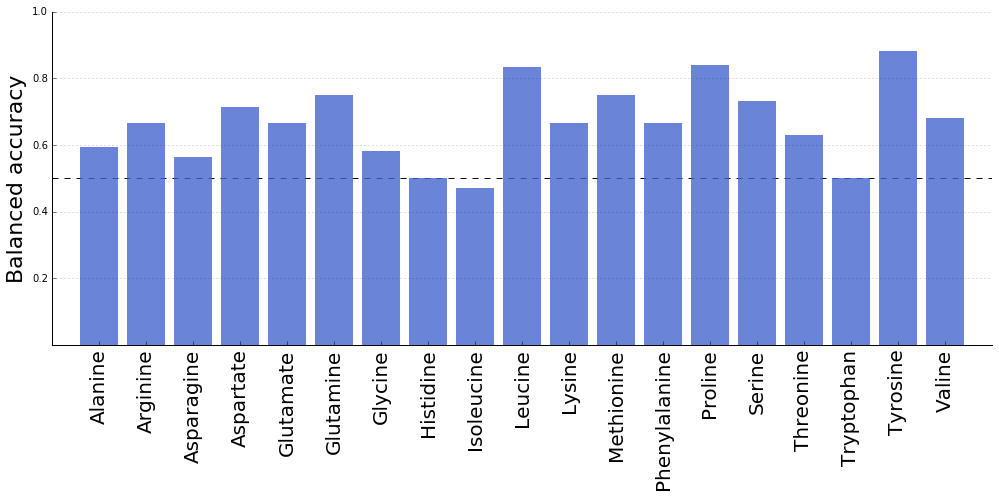

In [230]:
fig = plt.figure(figsize=[14, 7])
ax = fig.add_subplot(1, 1, 1)
plt.plot([-1, 19], [0.5, 0.5], "k--", zorder=0)
w = 0.8

sorted_aa = sorted(results)

plt.bar(
    np.arange(len(results))-w/2, [results[aa]["best_bac"] for aa in sorted_aa],
    facecolor="#4565cf", linewidth=0, width=w, alpha=0.8)
plt.ylim([0, 1])
plt.xlim([-1, 19])
plt.ylabel("Balanced accuracy", fontsize=22)
plt.xticks(range(len(results)), rotation="vertical", fontsize=20)

plt.yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_xticklabels([aa.capitalize() for aa in sorted_aa])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.spines['bottom'].set_visible(False)
#ax.spines['left'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

ax.grid(which="major", axis="y", alpha=0.5)

plt.savefig("../Plots/Reports/Concentration_from_concentration.pdf", bbox_inches="tight")

fig.tight_layout()

None

0.5625
[[28  0]
 [ 7  1]]

0.727272727273
[[64  0]
 [ 6  5]]


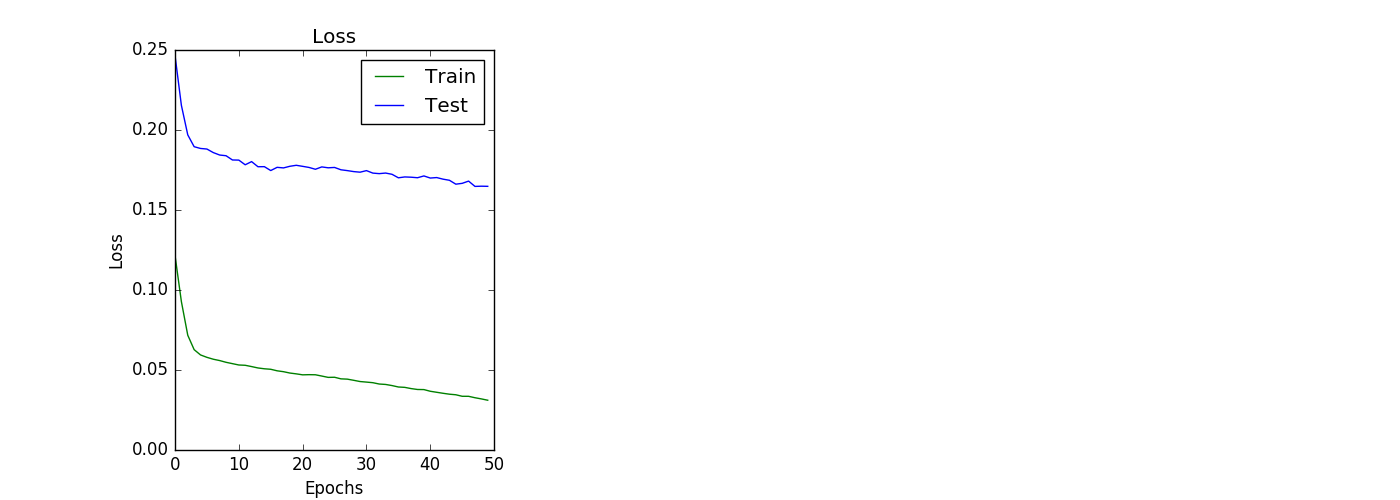

49


In [228]:
X_train[:, :, np.array([True, False, True, False, True])]

IndexError: too many indices for array

In [229]:
X_train.shape

(75, 19)